In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da

from matplotlib import pyplot as plt
%matplotlib inline

Initialize the spatial and temporal limits for this analysis - will be applied to all datasets

In [2]:
lat_min, lat_max = 65.479474, 68.708048
lon_min, lon_max = -169.259880, -160.007140

start_date = pd.datetime(2003,1,1)
end_date = pd.datetime(2018,11,1)
ddts = pd.date_range(start=start_date,end=end_date) #"daily-date-times"

# SST Data Products

## SST: MODIS

Pulling MODIS sst data from https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/contents.html

Filename conventions found at: ftp://podaac-ftp.jpl.nasa.gov/allData/modis/L3/docs/modis_fileinfo.txt

In [3]:
#create list of MODIS SST OpenDAP urls for all days in ddts
url_day = []
url_night = []
for day in ddts:
    yearday = day.strftime('%j')
    year = day.strftime('%Y')
    url_day.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/{yearday}/A{year}{yearday}.L3m_DAY_SST_sst_4km.nc')
    url_night.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/{yearday}/A{year}{yearday}.L3m_DAY_NSST_sst_4km.nc')
 

In [19]:
#Write a for loop to generate urls. Iterate through years and days 1-365, then throw a conditional at the end of it for the leap years. 
url_day = []
url_night = []
years = np.arange(2003, 2019)
for year in years:
    #we have 4 cases for the days: 1-digit, 2-digit, 3-digit, and leap year
    for day in np.arange(1,10):   
        url_day.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/00{day}/A{year}00{day}.L3m_DAY_SST_sst_4km.nc')
        url_night.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/00{day}/A{year}00{day}.L3m_DAY_NSST_sst_4km.nc')
    
    for day in np.arange(10,100):
        url_day.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/0{day}/A{year}0{day}.L3m_DAY_SST_sst_4km.nc')
        url_night.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/0{day}/A{year}0{day}.L3m_DAY_NSST_sst_4km.nc')
    
    for day in np.arange(100,366):
        url_day.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/{day}/A{year}{day}.L3m_DAY_SST_sst_4km.nc')
        url_night.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/{day}/A{year}{day}.L3m_DAY_NSST_sst_4km.nc')
    
    if year==2004 or year==2008 or year==2012 or year==2016:
        url_day.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/366/A{year}366.L3m_DAY_SST_sst_4km.nc')
        url_night.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/366/A{year}366.L3m_DAY_NSST_sst_4km.nc')

In [75]:
#DAYTIME IMPORTING
#import and slice the first one before getting into a for loop
sst_mod_day = xr.open_dataset(url_day[0]).sel(lat=slice(lat_max,lat_min), lon=slice(lon_min,lon_max)) #latitude variable is monotonically decreasing from 90 down.
#add new time dimensional coordinate
startTime = pd.to_datetime(sst_mod_day.attrs['time_coverage_start'])
endTime = pd.to_datetime(sst_mod_day.attrs['time_coverage_end'])
midTime = (endTime - startTime)/2 + startTime
sst_mod_day = sst_mod_day.assign_coords(time=midTime)
sst_mod_day = sst_mod_day.expand_dims('time')

#now do the rest of them in a for loop
from tqdm import tqdm #progress bar for sanity
for url in tqdm(url_day[1:]):
    #import and slice
    ds_day = xr.open_dataset(url).sel(lat=slice(lat_max,lat_min), lon=slice(lon_min,lon_max)) #latitude variable is monotonically decreasing from 90 down.
    #add new time dimensional coordinate
    startTime = pd.to_datetime(ds_day.attrs['time_coverage_start'])
    endTime = pd.to_datetime(ds_day.attrs['time_coverage_end'])
    midTime = (endTime - startTime)/2 + startTime
    ds_day = ds_day.assign_coords(time=midTime)
    ds_day = ds_day.expand_dims('time')    
    
    sst_mod_day = xr.auto_combine([sst_mod_day,ds_day],concat_dim='time')

sst_mod_day
    

100%|██████████| 5783/5783 [4:24:36<00:00,  3.68s/it]


<xarray.Dataset>
Dimensions:   (eightbitcolor: 256, lat: 77, lon: 222, rgb: 3, time: 5784)
Coordinates:
  * lat       (lat) float32 68.68749 68.64583 68.604164 68.56249 68.52083 ...
  * lon       (lon) float32 -169.22917 -169.1875 -169.14584 -169.10417 ...
  * time      (time) datetime64[ns] 2003-01-01T13:30:05 2003-01-02T13:35:05 ...
Dimensions without coordinates: eightbitcolor, rgb
Data variables:
    palette   (time, rgb, eightbitcolor) int8 91 10 118 99 9 -117 112 7 -85 ...
    sst       (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...
    qual_sst  (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...

In [5]:
#NIGHTTIME IMPORTING
#import and slice the first one before getting into a for loop
sst_mod_night = xr.open_dataset(url_night[0]).sel(lat=slice(lat_max,lat_min), lon=slice(lon_min,lon_max)) #latitude variable is monotonically decreasing from 90 down.
#add new time dimensional coordinate
startTime = pd.to_datetime(sst_mod_night.attrs['time_coverage_start'])
endTime = pd.to_datetime(sst_mod_night.attrs['time_coverage_end'])
midTime = (endTime - startTime)/2 + startTime
sst_mod_night = sst_mod_night.assign_coords(time=midTime)
sst_mod_night = sst_mod_night.expand_dims('time')

#now do the rest of them in a for loop
from tqdm import tqdm #progress bar for sanity
for url in tqdm(url_night[1:]):
    #import and slice
    ds_night = xr.open_dataset(url).sel(lat=slice(lat_max,lat_min), lon=slice(lon_min,lon_max)) #latitude variable is monotonically decreasing from 90 down.
    #add new time dimensional coordinate
    startTime = pd.to_datetime(ds_night.attrs['time_coverage_start'])
    endTime = pd.to_datetime(ds_night.attrs['time_coverage_end'])
    midTime = (endTime - startTime)/2 + startTime
    ds_night = ds_night.assign_coords(time=midTime)
    ds_night = ds_night.expand_dims('time')    
    
    sst_mod_night = xr.auto_combine([sst_mod_night,ds_night],concat_dim='time')

sst_mod_night.to_netcdf(path='sst_modis_night.nc')
    

100%|██████████| 5783/5783 [3:25:33<00:00,  2.45s/it]


In [77]:
sst_mod_day.to_netcdf(path='sst_modis_day.nc')

# All Importing Above can be skipped by running the below line

In [78]:
sst_mod_day = xr.open_dataset('sst_modis_day.nc')

## SST: Reynolds

Reynolds' Paper: https://journals.ametsoc.org/doi/full/10.1175/2007JCLI1824.1

Data Access: https://www.ncei.noaa.gov/thredds/catalog/OisstBase/NetCDF/AVHRR/catalog.html

In [5]:
#create list of Reynolds SST OpenDAP urls for all days in ddts
url_rey = []
for day in ddts:
    yearmonth = day.strftime('%Y%m')
    yearmonthday = day.strftime('%Y%m%d')
    url_rey.append(f'http://www.ncei.noaa.gov/thredds/dodsC/OisstBase/NetCDF/AVHRR/{yearmonth}/avhrr-only-v2.{yearmonthday}.nc')

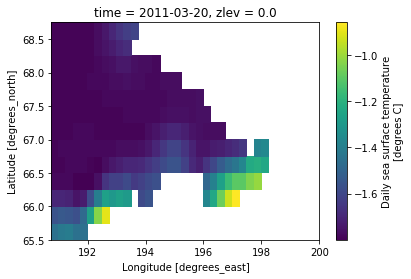

In [6]:
reynolds = xr.open_dataset(url_rey[3000])
reynolds.sel(lat=slice(lat_min,lat_max), lon=slice((lon_min+360)%360, (lon_max+360)%360)).sst.plot() #lon values are 0-360 in this dataset

In [8]:
sst_rey = xr.open_dataset(url_rey[0]).sel(lat=slice(lat_min,lat_max), lon=slice((lon_min+360)%360, (lon_max+360)%360)) #lon values are 0-360 in this dataset

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 37, time: 1, zlev: 1)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01
  * zlev     (zlev) float32 0.0
  * lat      (lat) float32 65.625 65.875 66.125 66.375 66.625 66.875 67.125 ...
  * lon      (lon) float32 190.875 191.125 191.375 191.625 191.875 192.125 ...
Data variables:
    sst      (time, zlev, lat, lon) float32 ...
    anom     (time, zlev, lat, lon) float32 ...
    err      (time, zlev, lat, lon) float32 ...
    ice      (time, zlev, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          Daily-OI-V2, final, Data (Ship, Buoy, AVHRR, GSFC-ice)
    History:        Version 2.0
    creation_date:  2011-03-08
    source_data:    ESRL ICOADS, AVHRR17, GSFC ice
    Source:         NOAA/National Climatic Data Center
    Contact:        Dick Reynolds, email: Richard.W.Reynolds@noaa.gov & Chuny...

In [ ]:
sst_rey = xr.open_dataset(url_rey[0]).sel(lat=slice(lat_min,lat_max), lon=slice((lon_min+360)%360, (lon_max+360)%360)) #lon values are 0-360 in this dataset

from tqdm import tqdm #progress bar for sanity

for url in tqdm(url_rey[3447:]):
    ds_rey = xr.open_dataset(url).sel(lat=slice(lat_min,lat_max), lon=slice((lon_min+360)%360, (lon_max+360)%360))   
    sst_rey = xr.auto_combine([sst_rey,ds_rey])
    
sst_rey
    

In [26]:
sst_rey

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 37, time: 5783, zlev: 1)
Coordinates:
  * zlev     (zlev) float32 0.0
  * lat      (lat) float32 65.625 65.875 66.125 66.375 66.625 66.875 67.125 ...
  * lon      (lon) float32 190.875 191.125 191.375 191.625 191.875 192.125 ...
  * time     (time) datetime64[ns] 2003-01-01 2003-01-02 2003-01-03 ...
Data variables:
    sst      (time, zlev, lat, lon) float32 -1.13 -1.11 -1.09 -1.03 ...
    anom     (time, zlev, lat, lon) float32 0.04 0.049999997 0.07 0.12 0.21 ...
    err      (time, zlev, lat, lon) float32 0.13 0.13 0.13 0.13 0.13 nan nan ...
    ice      (time, zlev, lat, lon) float32 0.85999995 0.85999995 0.82 0.83 ...

In [33]:
sst_rey.to_netcdf(path='sst_reynolds.nc')

# All Importing Above can be skipped by running the below line

In [ ]:
sst_rey = xr.open_dataset('sst_reynolds.nc')
sst_rey

# Sea Ice Concentration Data Products

## Sea Ice: AMSR2

## Sea Ice: Polar Pangeo